In [203]:
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import math
from random import *
from dateutil.parser import parse
warnings.filterwarnings("ignore")
%matplotlib inline

plt.style.use('ggplot')

In [189]:
dt_index = pd.DataFrame(pd.date_range(start='20110101', end='20191231')).rename(columns = {0 : 'date'})
dt_month_index = pd.DataFrame(pd.date_range(start='20110101', end='20191231',freq='MS')).rename(columns = {0 : 'date'})

def processing_potato_price(data):
    # print("======= data processing start ===========")
    # print(data.shape)
    # 중복값 제거
    data = data.drop_duplicates()
       
    # before, now / string to int
    data['before'] = data['before'].apply(lambda x : int(x.replace(',','')))
    data['now'] = data['now'].apply(lambda x : int(x.replace(',','')))
    
    # name 통합
    data['name'] = data['name'].apply(lambda x : x.replace('감자(수미)', '감자 수미').replace('감자(대지마)', '감자 대지'))
    
    # 감자 수미 or 감자 대지 선택
    string = '감자 수미' # 감자 수미 or 감자 대지
    subdata = data[data['name'] == '감자 대지']
    data = data[data['name'] == string]
    
    # 20110101-20191231 인덱스 설정
    data['date'] = data['date'].apply(lambda x : parse(str(x)))
    data = pd.merge(dt_index, data, how = 'left', on = 'date').set_index('date')
    
    subdata['date'] = subdata['date'].apply(lambda x : parse(str(x)))
    subdata = pd.merge(dt_index, subdata, how = 'left', on = 'date').set_index('date')
    
    # name 통일
    data['name'] = string
    
    # null 값 채우기
    # 1) 0값을 null값으로
    def zero_to_nan(data):
        if math.isnan(data): return data
        elif data == 0: return np.nan
        else: return data

    data['before'] = data['before'].apply(zero_to_nan)
    data['now'] = data['now'].apply(zero_to_nan)
    
    # 2) now가 null 값일 때 다음날 before값이 존재할 때
    random_value = 10
    data['Fill_value'] = data.shift(-1)['before']
    data['now'] = data[['now', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['now']) else x['now'], axis = 1)
    
    # 3) 2014-04-01 ~ 2015-04-40 수미 감자 null 값을 대지 감자 price로 대체
    data['sub_now'] = subdata['now']
    data['tmp_date'] = data.index
    def fill_null_to_sub_now(data):
        if str(data['tmp_date']) > '2014-03-31' and str(data['tmp_date']) <= '2015-04-30': return data['sub_now']
        else: return data['now']
    data['now'] = data[['now','tmp_date','sub_now']].apply(fill_null_to_sub_now, axis = 1)
    
    # 4) 이전 날의 값으로 null값 대체
    data = data.fillna(method='ffill')
    data = data.fillna(method='bfill')
    
    # 불필요한 columns drop
    data.drop(['name','before','Fill_value','sub_now','tmp_date'],axis = 1,inplace = True)
    data.rename(columns = {'now' : 'potato_price'}, inplace = True)
    # print(data.head())
    # print(data.isnull().sum().sum())
    print(data.head(3))
    # print("======= data processing finish ===========")
    print()
    return data

In [153]:
def processing_Exchange_Rate(data):
    print('start')
    # 20110101부터 정렬
    data = data[::-1]
    # format datetime으로 변경
    data['날짜'] = data['날짜'].apply(lambda x : parse(x[:4] + x[6:8] + x[10:12]))
    # 20110101-20191231 인덱스 설정
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    #print('전처리 전 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    # type 변경 str -> float
    data['종가'] = data['종가'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    data['오픈'] = data['오픈'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    
    # 주말 Null값 채우기
        
    # 일요일 : 월요일 오픈 가격으로 대체
    data['Fill_value'] = data.shift(-1)['오픈']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['종가']) else x['종가'], axis = 1)
    #print('전처리 후 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    
    # 토요일 : 금요일 종가 + random value
    random_value = 1
    data['Fill_value'] = data.shift(1)['종가']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] + uniform(-random_value, random_value) if math.isnan(x['종가']) else x['종가'], axis = 1)

    data.drop(['날짜', '오픈', '고가', '저가', '변동 %', 'Fill_value'], axis = 1, inplace = True)    
                      
    #print('전처리 후 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    data.rename(columns = {'종가' : 'Exchange_Rate'}, inplace = True)
    
    data = data.fillna(method='bfill')
    print(data.head(3))
    print('end')
    print()
    return data

In [154]:
def processing_KOSPI(data):
    print('start')
    # 20110101부터 정렬
    data = data[::-1]
    
    # format datetime으로 변경
    data['날짜'] = data['날짜'].apply(lambda x : parse(x[:4] + x[6:8] + x[10:12]))
    
    # 20110101-20191231 인덱스 설정
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    # type 변경 str -> float
    data['종가'] = data['종가'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    data['오픈'] = data['오픈'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    
    
    # 주말 Null값 채우기
        
    # 일요일 : 월요일 오픈 가격으로 대체
    data['Fill_value'] = data.shift(-1)['오픈']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['종가']) else x['종가'], axis = 1)
    
    random_value = 1
    data['Fill_value'] = data.shift(1)['종가']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] + uniform(-random_value, random_value) if math.isnan(x['종가']) else x['종가'], axis = 1)
    
    pd.set_option('display.float_format', '{:.2f}'.format) # 항상 float 형식으로
    
    data.drop(['날짜', '오픈', '고가', '저가', '거래량','변동 %', 'Fill_value'], axis = 1, inplace = True)    
    data.rename(columns = {'종가' : 'KOSPI'}, inplace = True)
    
    data = data.fillna(method='bfill')
    print(data.head(3))
    print('end')
    print()
    return data

In [155]:
def processing_Consumer_trend_survey(data):
    print('start')
    data = data.T
    data.columns = data.loc['항목명1', :]
    data = data.iloc[17:-3, :5].astype('int').reset_index()
    
    # Consumer_trend_survey
    result = pd.concat([dt_month_index, data], axis = 1, ignore_index=True).set_index(0)
    result.columns = data.columns    
    
    result.drop(['index'], axis = 1, inplace = True)
    
    print(result.head(3))
    print('end')
    print()
    return result

In [156]:
def processing_Oil_prices(data):
    print('start')
    
    data['날짜'] = data['기간'].apply(lambda x : parse('20' + x[:2] + x[3:5] + x[6:8]))
    
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    
    # null 값 처리
    data = data.fillna('-')
    data['Dubai'] = data['Dubai'].apply(lambda x : np.nan if x == '-' else float(x))
    data['Brent'] = data['Brent'].apply(lambda x : np.nan if x == '-' else float(x))
    data['WTI'] = data['WTI'].apply(lambda x : np.nan if x == '-' else float(x))
    
    data = data.fillna(method='bfill')
    data.drop(['기간','날짜'], axis = 1, inplace = True)    
    
    print(data.head(3))
    print('end')
    print()
    return data

In [157]:
def processing_Market_interest_rates(data):
    print('start')
    
    data = data.iloc[3:-8,:].rename(columns = {'통계표' : '날짜', '4.1.1 시장금리(일별)' : '시장금리'})
    
    data['날짜'] = data['날짜'].apply(lambda x : parse(x))
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    
    data['시장금리'] = data['시장금리'].apply(lambda x : x if x is np.nan else float(x))
    data = data.fillna(method='bfill')
    
    data.drop(['날짜'], axis = 1, inplace = True)
    
    print(data.head(3))
    print('end')
    return data

In [190]:
def load_data(sql):
    # print("======= data loading start ===========")
    conn = pymysql.connect(host='192.168.1.254', user='root', password='123456',
                           db='crawling', charset='utf8')
    curs = conn.cursor()
    curs.execute(sql)
    rows = curs.fetchall()
    # print("{}개의 데이터 로딩".format(len(rows)))
    data = pd.DataFrame(rows, columns=['name','now','before','date'])
    # print(data.head(3))
    # print("======= data loading finish ===========")
    # print()
    return data

def load_potato_price():
    sql = """
    SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date`
    FROM tbl_item WHERE tbl_item.`date` > '2011-01-01' and tbl_item.`품목` LIKE CONCAT('%' ,'%감자','%') 
    ORDER BY tbl_item.date ASC 
    """
    return load_data(sql)

def load_tomato_price():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item  
    WHERE tbl_item.`품목` LIKE '방울토마토%'
    """
    return load_data(sql)

def load_green_pepper():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item  
    WHERE tbl_item.`품목` IN ('풋고추(일반)', '풋고추')
    """
    return load_data(sql)

def load_red_pepper():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` IN ('풋고추(청양계)', '청양계풋고추')
    """
    return load_data(sql)

def load_cabbage():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '배추%'
    """
    return load_data(sql)

def load_cabbage1():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '양배추'
    """
    return load_data(sql)

def load_onion():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '양파'
    """
    return load_data(sql)

def load_carrot():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '당근'
    """
    return load_data(sql)

def load_green_onion():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '대파%'
    """
    return load_data(sql)

def load_cucumber():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '%백다다기%'
    """
    return load_data(sql)

def processing_data(data, name):
    print('start')
    
    data['now'] = data['now'].apply(lambda x : int(x.replace(',','')))
    data['before'] = data['before'].apply(lambda x : int(x.replace(',','')))
    data['date'] = data['date'].apply(lambda x : parse(str(x)))
    
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='date').set_index('date')
    
    # fill null value
    def zero_to_nan(data):
        if math.isnan(data): return data
        elif data == 0: return np.nan
        else: return data

    data['before'] = data['before'].apply(zero_to_nan)
    data['now'] = data['now'].apply(zero_to_nan)
    
    data['Fill_value'] = data.shift(-1)['before']
    data['now'] = data[['now', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['now']) else x['now'], axis = 1)
    
    data = data.fillna(method='ffill')
    data = data.fillna(method='bfill').rename(columns = {'now' : name})
    
    data.drop(['name','before','Fill_value'], axis = 1, inplace = True)
    
    print(data.head(3))
    print('end')
    return data

In [191]:
if __name__ == "__main__":
    print('==========감자 가격 전처리=============')
    potato_price = processing_potato_price(load_potato_price())
    
    print('========방울토마토 가격 전처리==========')
    tomato_price = processing_data(load_tomato_price(), 'tomato')
    
    print('==========풋고추 가격 전처리============')
    green_pepper_price = processing_data(load_green_pepper(), 'green_pepper')
    
    print('==========청양고추 가격 전처리============')
    red_pepper_price = processing_data(load_red_pepper(), 'red_pepper')
    
    print('==========배추 가격 전처리============')
    cabbage_price = processing_data(load_cabbage(), 'cabbage')
    
    print('=========양배추 가격 전처리============')
    cabbage1_price = processing_data(load_cabbage1(), 'cabbage1')
    
    print('=========양파 가격 전처리============')
    onion_price = processing_data(load_onion(), 'onion')
    
    print('=========당근 가격 전처리============')
    carrot_price = processing_data(load_carrot(), 'carrot')
    
    print('=========대파 가격 전처리============')
    green_onion_price = processing_data(load_green_onion(), 'green_onion')
    
    print('=========오이 가격 전처리============')
    cucumber_price = processing_data(load_cucumber(), 'cucumber')
    
    print('============환율 전처리================')
    Exchange_Rate = processing_Exchange_Rate(pd.read_csv('USD_KRW.csv'))

    print('============코스피 전처리==============')
    KOSPI = processing_KOSPI(pd.read_csv('코스피지수 내역.csv'))

    print('========소비자 동향조사 전처리==========')
    Consumer_trend_survey = processing_Consumer_trend_survey(pd.read_csv('소비자동향조사.csv', encoding = 'cp949'))

    print('========국제 원유 가격 전처리==========')
    Oil_prices = processing_Oil_prices(pd.read_csv('원유(일).csv', encoding='cp949'))
    
    print('============시장 금리 전처리============')
    Market_interest_rates = processing_Market_interest_rates(pd.read_csv('시장금리(일).csv', encoding = 'cp949', error_bad_lines=False))

==========감자 가격 전처리=============
            potato_price
date                    
2011-01-01      31948.00
2011-01-02      31948.00
2011-01-03      31911.00

========방울토마토 가격 전처리==========
start
             tomato
date               
2011-01-01 19315.00
2011-01-02 19315.00
2011-01-03 26214.00
end
==========풋고추 가격 전처리============
start
            green_pepper
date                    
2011-01-01      27314.00
2011-01-02      27314.00
2011-01-03      31741.00
end
==========청양고추 가격 전처리============
start
            red_pepper
date                  
2011-01-01    35257.00
2011-01-02    35257.00
2011-01-03    36231.00
end
==========배추 가격 전처리============
start
            cabbage
date               
2011-01-01  9183.00
2011-01-02  9183.00
2011-01-03  9183.00
end
=========양배추 가격 전처리============
start
            cabbage1
date                
2011-01-01   9315.00
2011-01-02   9315.00
2011-01-03  11395.00
end
=========양파 가격 전처리============
start
             onion
date              
2011-01-0

b'Skipping line 3756: expected 2 fields, saw 3\n'


            시장금리
date            
2011-01-01  2.49
2011-01-02  2.49
2011-01-03  2.49
end


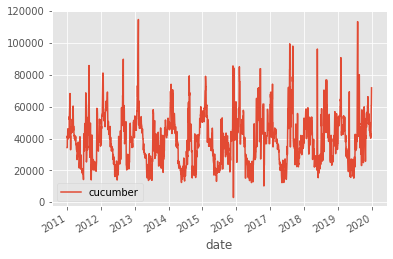

In [185]:
cucumber_price.plot()

In [186]:
result_data = pd.concat([potato_price, tomato_price, green_pepper_price, red_pepper_price, cabbage_price, cabbage1_price, onion_price, carrot_price, green_onion_price, cucumber_price, Exchange_Rate, KOSPI, Oil_prices, Market_interest_rates], axis = 1)

result_data.to_csv('result.csv', encoding = 'cp949')

In [194]:
def day_to_month(data):
    return data.resample('MS').mean()

result = pd.concat([Consumer_trend_survey, day_to_month(result_data)], axis = 1).corr()

result.style.background_gradient(cmap='summer_r')

,현재생활형편CSI,현재경기판단CSI,가계수입전망CSI,외식비 지출전망CSI,물가수준전망(1년후)CSI,potato_price,tomato,green_pepper,red_pepper,cabbage,cabbage1,onion,carrot,green_onion,cucumber,Exchange_Rate,KOSPI,Dubai,Brent,WTI,시장금리
현재생활형편CSI,1.000000,0.650280,0.512357,0.491710,-0.557313,0.236035,-0.288458,-0.141218,-0.194460,0.042647,-0.121489,0.012865,-0.279144,-0.085706,-0.103083,-0.119204,0.616827,-0.464422,-0.474007,-0.401349,-0.619705
현재경기판단CSI,0.650280,1.000000,0.758008,0.607717,-0.175040,0.164856,-0.241614,-0.139396,-0.161560,-0.095468,-0.243848,-0.023749,-0.308918,-0.367142,-0.164982,-0.459932,0.484805,0.086004,0.090851,0.141937,0.011825
가계수입전망CSI,0.512357,0.758008,1.000000,0.581325,-0.124332,0.251153,-0.072283,0.042357,0.033475,-0.051101,-0.088657,0.105082,-0.211553,-0.160289,0.017291,-0.449484,0.433385,-0.036586,-0.025629,0.009359,-0.047352
외식비 지출전망CSI,0.491710,0.607717,0.581325,1.000000,0.117635,0.362922,-0.165703,-0.214614,-0.258614,0.036620,-0.071408,-0.289589,-0.324660,-0.196737,-0.077867,-0.161997,0.606896,-0.152698,-0.156015,-0.142271,-0.220669
물가수준전망(1년후)CSI,-0.557313,-0.175040,-0.124332,0.117635,1.000000,0.154213,0.203960,-0.005165,-0.069149,-0.057987,0.103516,-0.168046,0.198782,-0.039681,0.044833,-0.027980,-0.013468,0.543425,0.547675,0.489423,0.547360
potato_price,0.236035,0.164856,0.251153,0.362922,0.154213,1.000000,0.168922,0.090723,0.009457,-0.055947,0.107635,-0.051310,-0.179316,-0.014604,0.000726,-0.084727,0.501116,-0.128221,-0.130366,-0.156573,-0.141554
tomato,-0.288458,-0.241614,-0.072283,-0.165703,0.203960,0.168922,1.000000,0.358718,0.334559,0.262998,0.362399,0.112291,0.280071,0.230017,0.456866,0.070875,-0.138775,0.166455,0.166150,0.115520,0.154660
green_pepper,-0.141218,-0.139396,0.042357,-0.214614,-0.005165,0.090723,0.358718,1.000000,0.736186,0.165157,0.081322,-0.035114,0.042508,0.082005,0.595903,-0.083603,-0.096899,0.052822,0.057837,0.044964,0.088488
red_pepper,-0.194460,-0.161560,0.033475,-0.258614,-0.069149,0.009457,0.334559,0.736186,1.000000,-0.023444,-0.024377,0.014834,-0.007973,0.054340,0.564395,0.009105,-0.146519,-0.027296,-0.018822,-0.058652,0.121676
cabbage,0.042647,-0.095468,-0.051101,0.036620,-0.057987,-0.055947,0.262998,0.165157,-0.023444,1.000000,0.640993,0.277866,0.316496,0.594973,0.281860,0.202328,0.108513,-0.185211,-0.179783,-0.186099,-0.247960


In [188]:
result_data.corr().style.background_gradient(cmap='summer_r')

,potato_price,tomato,green_pepper,red_pepper,cabbage,cabbage1,onion,carrot,green_onion,cucumber,Exchange_Rate,KOSPI,Dubai,Brent,WTI,시장금리
potato_price,1.000000,0.128438,0.063237,-0.003610,-0.042308,0.093250,-0.041402,-0.156784,-0.011936,0.005366,-0.080794,0.468825,-0.122106,-0.123654,-0.147640,-0.134098
tomato,0.128438,1.000000,0.251171,0.248097,0.214511,0.241841,0.088734,0.197286,0.143429,0.337071,0.057672,-0.094957,0.128490,0.128030,0.090579,0.116119
green_pepper,0.063237,0.251171,1.000000,0.685171,0.172724,0.108658,-0.025918,0.043078,0.118905,0.446137,-0.077401,-0.066722,0.048568,0.052204,0.041299,0.070680
red_pepper,-0.003610,0.248097,0.685171,1.000000,0.007990,0.004256,0.010106,-0.002876,0.100363,0.465360,0.000326,-0.126290,-0.022448,-0.014676,-0.052039,0.110665
cabbage,-0.042308,0.214511,0.172724,0.007990,1.000000,0.566028,0.239707,0.284031,0.512466,0.239498,0.173849,0.095119,-0.164154,-0.159624,-0.166747,-0.219912
cabbage1,0.093250,0.241841,0.108658,0.004256,0.566028,1.000000,0.247659,0.322346,0.569804,0.130084,0.221466,0.036361,-0.068464,-0.068075,-0.090946,-0.124966
onion,-0.041402,0.088734,-0.025918,0.010106,0.239707,0.247659,1.000000,0.341047,0.501579,0.108291,0.194156,-0.014663,-0.165615,-0.153111,-0.179908,-0.104309
carrot,-0.156784,0.197286,0.043078,-0.002876,0.284031,0.322346,0.341047,1.000000,0.240135,0.023174,-0.058007,-0.094291,0.278183,0.276237,0.231074,0.170642
green_onion,-0.011936,0.143429,0.118905,0.100363,0.512466,0.569804,0.501579,0.240135,1.000000,0.213398,0.364605,-0.009913,-0.266398,-0.263324,-0.295459,-0.245328
cucumber,0.005366,0.337071,0.446137,0.465360,0.239498,0.130084,0.108291,0.023174,0.213398,1.000000,0.086648,-0.007920,-0.083597,-0.083551,-0.100423,-0.058379


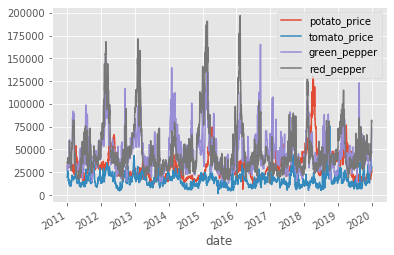

In [16]:
result_data[['potato_price', 'tomato_price', 'green_pepper', 'red_pepper']].plot()

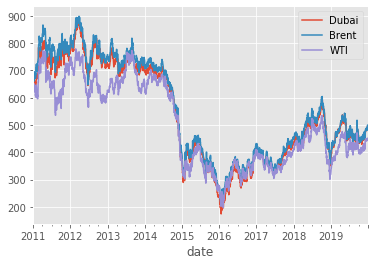

In [17]:
Oil_prices.plot()

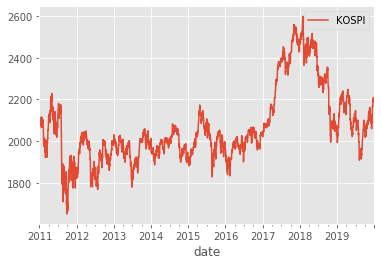

In [18]:
KOSPI.plot()